In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


# UK Prediction

In [2]:
# new file containing rows with our focused area of Dublin found through exploratory analysis
irl = pd.read_csv('leeds-data-1417.csv', index_col='Unnamed: 0')
irl1 = pd.read_csv('leeds-data-1821.csv', index_col='Unnamed: 0')

In [3]:
irl2 = pd.concat([irl, irl1], axis=0)

In [4]:
irl = irl2.copy()

In [5]:
irl.head()

,Transaction unique identifier,Price,Postcode,Property Type,Old/New,Duration,HouseNum,Add1,Add2,Add3,Town/City,District,County,PPDCategory Type,Month,Year
465,{50F18103-63C0-9FD5-E050-A8C063054923},210000,LS25 6NJ,D,N,F,6,NaN,BOND INGS RISE,SHERBURN IN ELMET,LEEDS,SELBY,NORTH YORKSHIRE,A,5,2017
959,{50F18103-63D7-9FD5-E050-A8C063054923},180000,LS25 6BN,D,N,F,1,NaN,RUDSTONE GROVE,SHERBURN IN ELMET,LEEDS,SELBY,NORTH YORKSHIRE,A,4,2017
2520,{68FEB20C-3CBE-38DA-E053-6C04A8C051AE},142500,LS19 7GL,F,Y,L,61,NaN,DYEHOUSE WALK,YEADON,LEEDS,LEEDS,WEST YORKSHIRE,A,12,2017
2536,{68FEB20C-3CCF-38DA-E053-6C04A8C051AE},102000,LS18 5NP,F,N,L,GRESLEY HOUSE,2,SUSSEX AVENUE,HORSFORTH,LEEDS,LEEDS,WEST YORKSHIRE,A,12,2017
2539,{68FEB20C-3CD2-38DA-E053-6C04A8C051AE},250000,LS19 7FU,S,Y,F,3,NaN,WEAVERS BECK WAY,YEADON,LEEDS,LEEDS,WEST YORKSHIRE,A,9,2017


In [6]:
irl.shape

(41033, 16)

In [7]:
irl.drop(columns = ['Transaction unique identifier', 'Town/City', 'Add1', 'HouseNum'], inplace = True)

In [8]:
irl = irl.dropna()

In [9]:
dt = list(irl['Postcode'])
ps = []
for i in range(len(dt)):
    strg = dt[i][:4]
    ps.append(strg)

In [10]:
ps[0]

'LS25'

In [11]:
irl['Postcode'] = ps

In [12]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [13]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price'])

In [14]:
encoder = TargetEncoder()
irl['District'] = encoder.fit_transform(irl['District'], irl['Price'])

In [15]:
encoder = TargetEncoder()
irl['Add3'] = encoder.fit_transform(irl['Add3'], irl['Price'])

In [16]:
encoder = TargetEncoder()
irl['Postcode'] = encoder.fit_transform(irl['Postcode'], irl['Price'])

In [17]:
encoder = TargetEncoder()
irl['Add2'] = encoder.fit_transform(irl['Add2'], irl['Price'])

In [18]:
#categorical data
categorical_cols = ['Property Type', 'Old/New', 'Duration', 'PPDCategory Type'] 

#import pandas as pd
df = pd.get_dummies(irl, columns = categorical_cols)

In [19]:
df.head()

,Price,Postcode,Add2,Add3,District,County,Month,Year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B
465,210000,218116.525847,258753.357049,224647.939686,236388.525078,256968.082345,5,2017,1,0,0,0,0,1,0,1,0,1,0
959,180000,218116.525847,205495.406300,224647.939686,236388.525078,256968.082345,4,2017,1,0,0,0,0,1,0,1,0,1,0
2520,142500,231355.747319,243485.169492,203921.998368,230438.749577,230437.210760,12,2017,0,1,0,0,0,0,1,0,1,1,0
2536,102000,278999.853118,186296.875000,278999.853118,230438.749577,230437.210760,12,2017,0,1,0,0,0,1,0,0,1,1,0
2539,250000,231355.747319,254714.756086,203921.998368,230438.749577,230437.210760,9,2017,0,0,0,1,0,0,1,1,0,1,0


In [20]:
irl = df

In [21]:
irl.head()

,Price,Postcode,Add2,Add3,District,County,Month,Year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B
465,210000,218116.525847,258753.357049,224647.939686,236388.525078,256968.082345,5,2017,1,0,0,0,0,1,0,1,0,1,0
959,180000,218116.525847,205495.406300,224647.939686,236388.525078,256968.082345,4,2017,1,0,0,0,0,1,0,1,0,1,0
2520,142500,231355.747319,243485.169492,203921.998368,230438.749577,230437.210760,12,2017,0,1,0,0,0,0,1,0,1,1,0
2536,102000,278999.853118,186296.875000,278999.853118,230438.749577,230437.210760,12,2017,0,1,0,0,0,1,0,0,1,1,0
2539,250000,231355.747319,254714.756086,203921.998368,230438.749577,230437.210760,9,2017,0,0,0,1,0,0,1,1,0,1,0


In [22]:
irl['PriceLog'] = np.log(irl['Price'])

In [23]:
irl.drop(columns = ['Price'], inplace = True)

In [24]:
irl.shape

(40965, 19)

### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [25]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [26]:
specific21[specific21['Year'] == 2021].head()

,Postcode,Add2,Add3,District,County,Month,Year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,PriceLog
1144,173908.371756,300787.500000,168993.186553,230438.749577,230437.21076,7,2021,1,0,0,0,0,1,0,1,0,1,0,12.823148
1987,172087.522876,123703.150028,145592.471125,230438.749577,230437.21076,11,2021,0,0,0,0,1,1,0,1,0,1,0,11.891362
1990,278999.853118,507271.773027,278999.853118,230438.749577,230437.21076,7,2021,1,0,0,0,0,1,0,1,0,1,0,13.681979
2003,400420.138054,328417.871528,329438.255034,230438.749577,230437.21076,8,2021,0,0,0,0,1,1,0,1,0,1,0,11.982929
2023,210744.850912,106687.528176,213710.799763,230438.749577,230437.21076,7,2021,0,0,0,0,1,1,0,1,0,1,0,11.652687


In [27]:
specific21.shape[0]

22549

In [28]:
train_21 = specific21[specific21['Year'] < 2021]

In [29]:
#train_21 = train_21.sample(n = 80000)
train_21.head()

,Postcode,Add2,Add3,District,County,Month,Year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,PriceLog
29838,278999.853118,271984.615384,278999.853118,230438.749577,230437.21076,11,2018,0,0,0,0,1,1,0,1,0,1,0,12.323856
29840,273531.472222,173987.759494,206134.230906,230438.749577,230437.21076,11,2018,1,0,0,0,0,1,0,1,0,1,0,12.472276
29842,290683.041423,231026.726609,287276.125746,230438.749577,230437.21076,11,2018,0,0,0,1,0,1,0,1,0,1,0,12.348006
29846,273531.472222,163597.181818,206134.230906,230438.749577,230437.21076,8,2018,0,0,0,1,0,1,0,1,0,1,0,12.278393
29985,173908.371756,140210.000517,168993.186553,230438.749577,230437.21076,5,2018,0,0,0,0,1,1,0,1,0,1,0,11.630709


In [30]:
test_21 = specific21[specific21['Year'] == 2021]

In [31]:
x_train_21 = train_21.loc[:, train_21.columns != 'PriceLog']
y_train_21 = train_21['PriceLog']

In [32]:
test_21.head()

,Postcode,Add2,Add3,District,County,Month,Year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B,PriceLog
1144,173908.371756,300787.500000,168993.186553,230438.749577,230437.21076,7,2021,1,0,0,0,0,1,0,1,0,1,0,12.823148
1987,172087.522876,123703.150028,145592.471125,230438.749577,230437.21076,11,2021,0,0,0,0,1,1,0,1,0,1,0,11.891362
1990,278999.853118,507271.773027,278999.853118,230438.749577,230437.21076,7,2021,1,0,0,0,0,1,0,1,0,1,0,13.681979
2003,400420.138054,328417.871528,329438.255034,230438.749577,230437.21076,8,2021,0,0,0,0,1,1,0,1,0,1,0,11.982929
2023,210744.850912,106687.528176,213710.799763,230438.749577,230437.21076,7,2021,0,0,0,0,1,1,0,1,0,1,0,11.652687


In [33]:
x_test_21 = test_21.loc[:, test_21.columns != 'PriceLog']
y_test_21 = test_21['PriceLog']

In [34]:
## explain_level gives information on feature importance when given value 1 or 2
automl1 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl1.fit(x_train_21, y_train_21)

Linear algorithm was disabled.
AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.587282 trained in 0.54 seconds
2_DecisionTree rmse 0.439299 trained in 19.4 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.329864 trained in 24.96 seconds
4_Default_NeuralNetwork rmse 0.368661 trained in 3.22 seconds
5_Default_RandomForest rmse 0.393176 trained in 7.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.32549 trained in 0.32 seconds
AutoML fit time: 69.71 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [35]:
# calculated values
y_predicted_21 = automl1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 0.11318998467720445


In [36]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 0.33643719276739376


In [37]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.35551285130915206


In [38]:
acc1 = accuracy_threshold(y_test_21, y_predicted_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6382416526543359


In [39]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14746483926688825


In [40]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.017269566384892746


In [41]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [42]:
#cnames = ['Actual', 'Predicted']
#dfreal1 = pd.DataFrame(columns = cnames)
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020 predictions

In [43]:
specific20 = irl[irl['Year'] > 2016]

In [44]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [45]:
x_train_20 = train_20.loc[:, train_20.columns != 'PriceLog']
y_train_20 = train_20['PriceLog']

In [46]:
x_test_20 = test_20.loc[:, test_20.columns != 'PriceLog']
y_test_20 = test_20['PriceLog']

In [47]:
automl2 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl2.fit(x_train_20, y_train_20)

Linear algorithm was disabled.
AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.582922 trained in 0.89 seconds
2_DecisionTree rmse 0.422985 trained in 6.31 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.337268 trained in 14.68 seconds
4_Default_NeuralNetwork rmse 0.38027 trained in 1.74 seconds
5_Default_RandomForest rmse 0.386989 trained in 4.81 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.334686 trained in 0.36 seconds
AutoML fit time: 45.52 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [48]:
# calculated values
y_predicted_20 = automl2.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_predicted_20)
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 0.11639432376297514


In [49]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 0.34116612341053904


In [50]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3681116825863336


In [51]:
acc1 = accuracy_threshold(y_test_20, y_predicted_20, 0.2)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6495224099926524


In [52]:
print("Median Absolute Error:\n")
print(median_absolute_error(y_test_20, y_predicted_20))

Median Absolute Error:

0.14639837621305318


In [53]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.017337591167771386


In [54]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

In [55]:
x_test_20

,Postcode,Add2,Add3,District,County,Month,Year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,Old/New_N,Old/New_Y,Duration_F,Duration_L,PPDCategory Type_A,PPDCategory Type_B
0,218116.525847,328417.871528,310611.194030,236388.525078,256968.082345,11,2020,0,0,0,1,0,1,0,1,0,1,0
1,218116.525847,244115.312994,262724.335294,236388.525078,256968.082345,10,2020,1,0,0,0,0,0,1,1,0,1,0
2,218116.525847,307877.341142,224647.939686,236388.525078,256968.082345,12,2020,1,0,0,0,0,1,0,1,0,1,0
3,218116.525847,375427.950495,234782.222615,236388.525078,256968.082345,10,2020,1,0,0,0,0,1,0,1,0,1,0
4,218116.525847,186356.957895,234782.222615,236388.525078,256968.082345,11,2020,1,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4078,273531.472222,132604.666667,191745.094737,230438.749577,230437.210760,7,2020,0,1,0,0,0,1,0,0,1,1,0
4079,231355.747319,290812.500000,287343.938240,230438.749577,230437.210760,7,2020,0,0,0,1,0,1,0,1,0,1,0
4080,173661.602210,191586.436782,154995.620573,230438.749577,230437.210760,6,2020,0,0,0,0,1,1,0,0,1,1,0
4081,218116.525847,225045.791083,224647.939686,236388.525078,256968.082345,1,2020,1,0,0,0,0,1,0,1,0,1,0


In [56]:
#cnames = ['Actual', 'Predicted']
#dfreal2 = pd.DataFrame(columns = cnames)
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)
#dfreal2 = pd.concat([z1, z2], ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [57]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [58]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [59]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 0.1254671353553587


In [60]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.321402834494355


In [61]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.5904395868364161


In [62]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16422260774511166


In [63]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.35421340369240467


In [64]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.01892435896397648


In [65]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [66]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [67]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 0.12906316525458136


In [68]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3423952975753123


In [69]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.15)
print('Accuracy of properties at +- 15% of actual prices is ' + str(acc1))

Accuracy of properties at +- 15% of actual prices is 0.4810188586823414


In [70]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15865581179864563


In [71]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3592536224654968


In [72]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.01889726829583677


In [73]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [74]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [75]:
model = AdaBoostRegressor()

In [76]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [77]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 0.20598739170074734


In [78]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.21426855632957


In [79]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.4376651453278885


In [80]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24647922115348564


In [81]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.45385833880270066


In [82]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.02562715783485102


In [83]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [84]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [85]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 0.21246559748917618


In [86]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.25789860396767084


In [87]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.5023267205486163


In [88]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.21065891271270587


In [89]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.46093990659214634


In [90]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.024369110782987095


In [91]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns = cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [92]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [93]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [94]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 0.10939941261085154


In [95]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3683566005388195


In [96]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6576047024246877


In [97]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14466064405308288


In [98]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3307558202221866


In [99]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.017018928481445282


In [100]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [101]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [102]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 0.11801269394411054


In [103]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3322123468652414


In [104]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6175834734566419


In [105]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1588636190599697


In [106]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3435297569994637


In [107]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.018009992455777175


In [108]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [109]:
from catboost import CatBoostRegressor

In [110]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.064859
0:	learn: 0.5754741	total: 148ms	remaining: 2m 28s
1:	learn: 0.5584849	total: 154ms	remaining: 1m 17s
2:	learn: 0.5414375	total: 160ms	remaining: 53s
3:	learn: 0.5262558	total: 165ms	remaining: 41s
4:	learn: 0.5123485	total: 171ms	remaining: 34.1s
5:	learn: 0.5003027	total: 177ms	remaining: 29.3s
6:	learn: 0.4889071	total: 182ms	remaining: 25.9s
7:	learn: 0.4779176	total: 188ms	remaining: 23.3s
8:	learn: 0.4684484	total: 194ms	remaining: 21.3s
9:	learn: 0.4585132	total: 200ms	remaining: 19.8s
10:	learn: 0.4505986	total: 205ms	remaining: 18.4s
11:	learn: 0.4435129	total: 210ms	remaining: 17.3s
12:	learn: 0.4372175	total: 216ms	remaining: 16.4s
13:	learn: 0.4311812	total: 222ms	remaining: 15.7s
14:	learn: 0.4252129	total: 231ms	remaining: 15.2s
15:	learn: 0.4202049	total: 237ms	remaining: 14.6s
16:	learn: 0.4144116	total: 242ms	remaining: 14s
17:	learn: 0.4104214	total: 248ms	remaining: 13.5s
18:	learn: 0.4065653	total: 253ms	remaining: 13s
19:	learn: 0.4030

166:	learn: 0.3093630	total: 1.63s	remaining: 8.12s
167:	learn: 0.3092331	total: 1.65s	remaining: 8.19s
168:	learn: 0.3089181	total: 1.67s	remaining: 8.19s
169:	learn: 0.3086656	total: 1.68s	remaining: 8.19s
170:	learn: 0.3084973	total: 1.69s	remaining: 8.2s
171:	learn: 0.3083659	total: 1.7s	remaining: 8.2s
172:	learn: 0.3082688	total: 1.71s	remaining: 8.2s
173:	learn: 0.3080092	total: 1.72s	remaining: 8.18s
174:	learn: 0.3078883	total: 1.73s	remaining: 8.16s
175:	learn: 0.3074312	total: 1.74s	remaining: 8.15s
176:	learn: 0.3072738	total: 1.75s	remaining: 8.15s
177:	learn: 0.3070322	total: 1.76s	remaining: 8.15s
178:	learn: 0.3067569	total: 1.77s	remaining: 8.13s
179:	learn: 0.3065341	total: 1.78s	remaining: 8.11s
180:	learn: 0.3064343	total: 1.79s	remaining: 8.09s
181:	learn: 0.3060899	total: 1.79s	remaining: 8.06s
182:	learn: 0.3058541	total: 1.81s	remaining: 8.07s
183:	learn: 0.3057541	total: 1.82s	remaining: 8.09s
184:	learn: 0.3054957	total: 1.84s	remaining: 8.09s
185:	learn: 0.30

336:	learn: 0.2814793	total: 3.12s	remaining: 6.13s
337:	learn: 0.2812289	total: 3.13s	remaining: 6.13s
338:	learn: 0.2811665	total: 3.14s	remaining: 6.13s
339:	learn: 0.2809062	total: 3.15s	remaining: 6.12s
340:	learn: 0.2807875	total: 3.17s	remaining: 6.12s
341:	learn: 0.2806778	total: 3.18s	remaining: 6.11s
342:	learn: 0.2805904	total: 3.19s	remaining: 6.11s
343:	learn: 0.2803178	total: 3.2s	remaining: 6.11s
344:	learn: 0.2802155	total: 3.21s	remaining: 6.1s
345:	learn: 0.2801576	total: 3.22s	remaining: 6.09s
346:	learn: 0.2799543	total: 3.24s	remaining: 6.09s
347:	learn: 0.2797538	total: 3.25s	remaining: 6.08s
348:	learn: 0.2796232	total: 3.26s	remaining: 6.08s
349:	learn: 0.2795269	total: 3.27s	remaining: 6.07s
350:	learn: 0.2793800	total: 3.28s	remaining: 6.07s
351:	learn: 0.2792981	total: 3.29s	remaining: 6.06s
352:	learn: 0.2791006	total: 3.31s	remaining: 6.06s
353:	learn: 0.2790516	total: 3.32s	remaining: 6.07s
354:	learn: 0.2787168	total: 3.34s	remaining: 6.07s
355:	learn: 0.

497:	learn: 0.2644226	total: 4.39s	remaining: 4.42s
498:	learn: 0.2642783	total: 4.39s	remaining: 4.41s
499:	learn: 0.2642157	total: 4.4s	remaining: 4.4s
500:	learn: 0.2641290	total: 4.4s	remaining: 4.38s
501:	learn: 0.2640858	total: 4.41s	remaining: 4.37s
502:	learn: 0.2640482	total: 4.41s	remaining: 4.36s
503:	learn: 0.2638959	total: 4.42s	remaining: 4.35s
504:	learn: 0.2638190	total: 4.43s	remaining: 4.34s
505:	learn: 0.2638018	total: 4.43s	remaining: 4.33s
506:	learn: 0.2637562	total: 4.44s	remaining: 4.32s
507:	learn: 0.2637241	total: 4.44s	remaining: 4.3s
508:	learn: 0.2636872	total: 4.46s	remaining: 4.3s
509:	learn: 0.2636567	total: 4.46s	remaining: 4.29s
510:	learn: 0.2636432	total: 4.47s	remaining: 4.27s
511:	learn: 0.2634943	total: 4.47s	remaining: 4.26s
512:	learn: 0.2633279	total: 4.48s	remaining: 4.25s
513:	learn: 0.2632288	total: 4.48s	remaining: 4.24s
514:	learn: 0.2631720	total: 4.49s	remaining: 4.22s
515:	learn: 0.2631261	total: 4.49s	remaining: 4.21s
516:	learn: 0.262

660:	learn: 0.2509484	total: 5.46s	remaining: 2.8s
661:	learn: 0.2509010	total: 5.46s	remaining: 2.79s
662:	learn: 0.2508120	total: 5.47s	remaining: 2.78s
663:	learn: 0.2507528	total: 5.48s	remaining: 2.77s
664:	learn: 0.2506701	total: 5.49s	remaining: 2.76s
665:	learn: 0.2505962	total: 5.49s	remaining: 2.75s
666:	learn: 0.2505543	total: 5.5s	remaining: 2.75s
667:	learn: 0.2504860	total: 5.51s	remaining: 2.74s
668:	learn: 0.2503847	total: 5.51s	remaining: 2.73s
669:	learn: 0.2503574	total: 5.52s	remaining: 2.72s
670:	learn: 0.2503063	total: 5.53s	remaining: 2.71s
671:	learn: 0.2502559	total: 5.54s	remaining: 2.7s
672:	learn: 0.2502122	total: 5.54s	remaining: 2.69s
673:	learn: 0.2501730	total: 5.55s	remaining: 2.68s
674:	learn: 0.2501133	total: 5.55s	remaining: 2.67s
675:	learn: 0.2500657	total: 5.56s	remaining: 2.67s
676:	learn: 0.2500134	total: 5.57s	remaining: 2.65s
677:	learn: 0.2499127	total: 5.57s	remaining: 2.65s
678:	learn: 0.2498517	total: 5.58s	remaining: 2.64s
679:	learn: 0.2

819:	learn: 0.2416403	total: 6.38s	remaining: 1.4s
820:	learn: 0.2416072	total: 6.38s	remaining: 1.39s
821:	learn: 0.2415801	total: 6.39s	remaining: 1.38s
822:	learn: 0.2414984	total: 6.39s	remaining: 1.38s
823:	learn: 0.2414519	total: 6.4s	remaining: 1.37s
824:	learn: 0.2413997	total: 6.41s	remaining: 1.36s
825:	learn: 0.2413377	total: 6.41s	remaining: 1.35s
826:	learn: 0.2413054	total: 6.42s	remaining: 1.34s
827:	learn: 0.2412703	total: 6.42s	remaining: 1.33s
828:	learn: 0.2412204	total: 6.43s	remaining: 1.33s
829:	learn: 0.2411195	total: 6.43s	remaining: 1.32s
830:	learn: 0.2410913	total: 6.44s	remaining: 1.31s
831:	learn: 0.2409945	total: 6.44s	remaining: 1.3s
832:	learn: 0.2409723	total: 6.45s	remaining: 1.29s
833:	learn: 0.2409309	total: 6.46s	remaining: 1.28s
834:	learn: 0.2408813	total: 6.46s	remaining: 1.28s
835:	learn: 0.2408114	total: 6.46s	remaining: 1.27s
836:	learn: 0.2407745	total: 6.47s	remaining: 1.26s
837:	learn: 0.2407501	total: 6.47s	remaining: 1.25s
838:	learn: 0.2

992:	learn: 0.2333238	total: 7.32s	remaining: 51.6ms
993:	learn: 0.2332951	total: 7.32s	remaining: 44.2ms
994:	learn: 0.2332430	total: 7.33s	remaining: 36.8ms
995:	learn: 0.2332104	total: 7.33s	remaining: 29.5ms
996:	learn: 0.2331781	total: 7.34s	remaining: 22.1ms
997:	learn: 0.2331642	total: 7.35s	remaining: 14.7ms
998:	learn: 0.2331259	total: 7.35s	remaining: 7.36ms
999:	learn: 0.2330924	total: 7.36s	remaining: 0us


In [111]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 0.11119579774492655


In [112]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34662503002642325


In [113]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15573468028927806


In [114]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.33346033908836364


In [115]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.017700422395745073


In [116]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [117]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.065306
0:	learn: 0.5720913	total: 5.87ms	remaining: 5.86s
1:	learn: 0.5548045	total: 12.9ms	remaining: 6.46s
2:	learn: 0.5376330	total: 18.8ms	remaining: 6.26s
3:	learn: 0.5225290	total: 28.1ms	remaining: 7s
4:	learn: 0.5089898	total: 34.5ms	remaining: 6.86s
5:	learn: 0.4961205	total: 41.3ms	remaining: 6.83s
6:	learn: 0.4846120	total: 52.1ms	remaining: 7.38s
7:	learn: 0.4743342	total: 64.2ms	remaining: 7.96s
8:	learn: 0.4646582	total: 72.3ms	remaining: 7.96s
9:	learn: 0.4549726	total: 80.5ms	remaining: 7.96s
10:	learn: 0.4470279	total: 87.3ms	remaining: 7.85s
11:	learn: 0.4399426	total: 94.5ms	remaining: 7.78s
12:	learn: 0.4337444	total: 102ms	remaining: 7.77s
13:	learn: 0.4272696	total: 109ms	remaining: 7.7s
14:	learn: 0.4220995	total: 115ms	remaining: 7.58s
15:	learn: 0.4163232	total: 121ms	remaining: 7.45s
16:	learn: 0.4113499	total: 128ms	remaining: 7.39s
17:	learn: 0.4070268	total: 134ms	remaining: 7.29s
18:	learn: 0.4032370	total: 139ms	remaining: 7.19s
19:

168:	learn: 0.3061782	total: 1.62s	remaining: 7.96s
169:	learn: 0.3060977	total: 1.62s	remaining: 7.93s
170:	learn: 0.3058734	total: 1.63s	remaining: 7.9s
171:	learn: 0.3057288	total: 1.64s	remaining: 7.89s
172:	learn: 0.3054795	total: 1.65s	remaining: 7.88s
173:	learn: 0.3052439	total: 1.65s	remaining: 7.85s
174:	learn: 0.3051441	total: 1.66s	remaining: 7.82s
175:	learn: 0.3049464	total: 1.67s	remaining: 7.8s
176:	learn: 0.3048176	total: 1.67s	remaining: 7.77s
177:	learn: 0.3045537	total: 1.68s	remaining: 7.75s
178:	learn: 0.3043600	total: 1.68s	remaining: 7.73s
179:	learn: 0.3041499	total: 1.69s	remaining: 7.71s
180:	learn: 0.3040910	total: 1.7s	remaining: 7.69s
181:	learn: 0.3038919	total: 1.7s	remaining: 7.66s
182:	learn: 0.3037066	total: 1.71s	remaining: 7.63s
183:	learn: 0.3034849	total: 1.72s	remaining: 7.61s
184:	learn: 0.3030589	total: 1.72s	remaining: 7.59s
185:	learn: 0.3029622	total: 1.73s	remaining: 7.58s
186:	learn: 0.3027545	total: 1.74s	remaining: 7.55s
187:	learn: 0.30

343:	learn: 0.2781542	total: 2.71s	remaining: 5.16s
344:	learn: 0.2780121	total: 2.71s	remaining: 5.15s
345:	learn: 0.2778990	total: 2.72s	remaining: 5.14s
346:	learn: 0.2777753	total: 2.72s	remaining: 5.13s
347:	learn: 0.2776600	total: 2.73s	remaining: 5.12s
348:	learn: 0.2775770	total: 2.74s	remaining: 5.11s
349:	learn: 0.2774176	total: 2.74s	remaining: 5.09s
350:	learn: 0.2772384	total: 2.75s	remaining: 5.09s
351:	learn: 0.2771245	total: 2.76s	remaining: 5.08s
352:	learn: 0.2768672	total: 2.76s	remaining: 5.07s
353:	learn: 0.2767426	total: 2.77s	remaining: 5.06s
354:	learn: 0.2766689	total: 2.78s	remaining: 5.05s
355:	learn: 0.2764967	total: 2.79s	remaining: 5.04s
356:	learn: 0.2764160	total: 2.79s	remaining: 5.03s
357:	learn: 0.2762961	total: 2.8s	remaining: 5.03s
358:	learn: 0.2761487	total: 2.81s	remaining: 5.01s
359:	learn: 0.2760213	total: 2.81s	remaining: 5s
360:	learn: 0.2758800	total: 2.82s	remaining: 4.99s
361:	learn: 0.2758138	total: 2.83s	remaining: 4.99s
362:	learn: 0.27

518:	learn: 0.2616356	total: 3.95s	remaining: 3.66s
519:	learn: 0.2615617	total: 3.95s	remaining: 3.65s
520:	learn: 0.2615110	total: 3.96s	remaining: 3.64s
521:	learn: 0.2614602	total: 3.96s	remaining: 3.63s
522:	learn: 0.2614092	total: 3.97s	remaining: 3.62s
523:	learn: 0.2612946	total: 3.98s	remaining: 3.61s
524:	learn: 0.2611390	total: 3.98s	remaining: 3.6s
525:	learn: 0.2610755	total: 3.99s	remaining: 3.6s
526:	learn: 0.2610198	total: 4s	remaining: 3.59s
527:	learn: 0.2609017	total: 4s	remaining: 3.58s
528:	learn: 0.2607494	total: 4.01s	remaining: 3.57s
529:	learn: 0.2607097	total: 4.03s	remaining: 3.57s
530:	learn: 0.2605278	total: 4.04s	remaining: 3.57s
531:	learn: 0.2603846	total: 4.05s	remaining: 3.56s
532:	learn: 0.2603238	total: 4.16s	remaining: 3.64s
533:	learn: 0.2602858	total: 4.18s	remaining: 3.64s
534:	learn: 0.2602022	total: 4.2s	remaining: 3.65s
535:	learn: 0.2601726	total: 4.22s	remaining: 3.65s
536:	learn: 0.2600190	total: 4.23s	remaining: 3.65s
537:	learn: 0.2599787

685:	learn: 0.2503048	total: 5.28s	remaining: 2.42s
686:	learn: 0.2502683	total: 5.28s	remaining: 2.41s
687:	learn: 0.2502345	total: 5.29s	remaining: 2.4s
688:	learn: 0.2501836	total: 5.29s	remaining: 2.39s
689:	learn: 0.2500425	total: 5.3s	remaining: 2.38s
690:	learn: 0.2499893	total: 5.3s	remaining: 2.37s
691:	learn: 0.2498766	total: 5.31s	remaining: 2.36s
692:	learn: 0.2498279	total: 5.32s	remaining: 2.36s
693:	learn: 0.2497894	total: 5.39s	remaining: 2.38s
694:	learn: 0.2496951	total: 5.4s	remaining: 2.37s
695:	learn: 0.2496373	total: 5.42s	remaining: 2.37s
696:	learn: 0.2495878	total: 5.44s	remaining: 2.36s
697:	learn: 0.2494970	total: 5.45s	remaining: 2.36s
698:	learn: 0.2494634	total: 5.46s	remaining: 2.35s
699:	learn: 0.2493989	total: 5.48s	remaining: 2.35s
700:	learn: 0.2493588	total: 5.49s	remaining: 2.34s
701:	learn: 0.2493025	total: 5.5s	remaining: 2.33s
702:	learn: 0.2492151	total: 5.51s	remaining: 2.33s
703:	learn: 0.2491437	total: 5.51s	remaining: 2.32s
704:	learn: 0.249

863:	learn: 0.2402885	total: 6.87s	remaining: 1.08s
864:	learn: 0.2402363	total: 6.88s	remaining: 1.07s
865:	learn: 0.2401918	total: 6.88s	remaining: 1.06s
866:	learn: 0.2401620	total: 6.89s	remaining: 1.06s
867:	learn: 0.2401424	total: 6.9s	remaining: 1.05s
868:	learn: 0.2400707	total: 6.9s	remaining: 1.04s
869:	learn: 0.2400417	total: 6.91s	remaining: 1.03s
870:	learn: 0.2399926	total: 6.91s	remaining: 1.02s
871:	learn: 0.2399435	total: 6.92s	remaining: 1.02s
872:	learn: 0.2399065	total: 6.93s	remaining: 1.01s
873:	learn: 0.2398765	total: 6.95s	remaining: 1s
874:	learn: 0.2398406	total: 6.96s	remaining: 994ms
875:	learn: 0.2398003	total: 6.96s	remaining: 986ms
876:	learn: 0.2397212	total: 6.97s	remaining: 978ms
877:	learn: 0.2397042	total: 6.97s	remaining: 969ms
878:	learn: 0.2396347	total: 6.98s	remaining: 961ms
879:	learn: 0.2395890	total: 6.99s	remaining: 953ms
880:	learn: 0.2395704	total: 6.99s	remaining: 944ms
881:	learn: 0.2395288	total: 7s	remaining: 936ms
882:	learn: 0.239505

In [118]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.11040445928652741


In [119]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.3712956159686505


In [120]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1416679873715676


In [121]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.33227166488662147


In [122]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.016893134049152922


In [123]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [124]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [125]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [126]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print(mse)

0.12543182660494895


In [127]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.31996156617823684


In [128]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16386536959626774


In [129]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.35416355911492203


In [130]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.018922308115674278


In [131]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [132]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [133]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.1290174636967731


In [134]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.34215037962282635


In [135]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1584423236364252


In [136]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.35919001057486716


In [137]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.018894259945875607


In [138]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [139]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [140]:
specific19 = irl[irl['Year'] > 2015]

In [141]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

In [142]:
x_train_19 = train_19.loc[:, train_19.columns != 'PriceLog']
y_train_19 = train_19['PriceLog']
x_test_19 = test_19.loc[:, test_19.columns != 'PriceLog']
y_test_19 = test_19['PriceLog']

#### AutoML

In [143]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_19, y_train_19)

Linear algorithm was disabled.
AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.602206 trained in 1.45 seconds
2_DecisionTree rmse 0.434189 trained in 7.87 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.292794 trained in 14.91 seconds
4_Default_NeuralNetwork rmse 0.375956 trained in 2.86 seconds
5_Default_RandomForest rmse 0.385708 trained in 6.22 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.292794 trained in 0.32 seconds
AutoML fit time: 51.51 seconds
AutoML best model: 3_Default_Xgboost


AutoML(explain_level=2, total_time_limit=300)

In [144]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 0.152035510663555


In [145]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3904382470119522


In [146]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 0.38991731259788276


In [147]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13404596887474618


In [148]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.017983648445562793


In [149]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [150]:
#cnames = ['Actual', 'Predicted']
#dfreal3 = pd.DataFrame(columns = cnames)
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_pred_19)
#dfreal3 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [151]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 0.16675034048679482


In [152]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.408350756686938


In [153]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15184578296245732


In [154]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.35101698469280773


In [155]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.01978454503060817


In [156]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [157]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 0.21417281920732048


In [158]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.46278809319959874


In [159]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.19070120461189433


In [160]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2746907108408471


In [161]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.02375451614073551


In [162]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [163]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 0.14278648492827517


In [164]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.37787098979450007


In [165]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13926169820193657


In [166]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3797441811700566


In [167]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.018046908644365367


In [168]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [169]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.065242
0:	learn: 0.5723513	total: 5.55ms	remaining: 5.55s
1:	learn: 0.5541408	total: 11.3ms	remaining: 5.63s
2:	learn: 0.5377662	total: 26.1ms	remaining: 8.69s
3:	learn: 0.5224566	total: 35.6ms	remaining: 8.85s
4:	learn: 0.5081181	total: 42.4ms	remaining: 8.44s
5:	learn: 0.4954851	total: 50.4ms	remaining: 8.36s
6:	learn: 0.4838880	total: 56.5ms	remaining: 8.02s
7:	learn: 0.4735183	total: 64.2ms	remaining: 7.96s
8:	learn: 0.4639889	total: 69.9ms	remaining: 7.7s
9:	learn: 0.4549772	total: 76.6ms	remaining: 7.58s
10:	learn: 0.4473105	total: 82.4ms	remaining: 7.41s
11:	learn: 0.4401622	total: 89.5ms	remaining: 7.37s
12:	learn: 0.4335074	total: 95.4ms	remaining: 7.24s
13:	learn: 0.4275938	total: 101ms	remaining: 7.13s
14:	learn: 0.4219777	total: 107ms	remaining: 7.03s
15:	learn: 0.4169048	total: 113ms	remaining: 6.95s
16:	learn: 0.4123741	total: 119ms	remaining: 6.87s
17:	learn: 0.4085375	total: 126ms	remaining: 6.85s
18:	learn: 0.4048853	total: 136ms	remaining: 7.01s

162:	learn: 0.3132320	total: 1.12s	remaining: 5.73s
163:	learn: 0.3130743	total: 1.12s	remaining: 5.72s
164:	learn: 0.3129487	total: 1.13s	remaining: 5.71s
165:	learn: 0.3127696	total: 1.13s	remaining: 5.7s
166:	learn: 0.3121308	total: 1.14s	remaining: 5.69s
167:	learn: 0.3118840	total: 1.15s	remaining: 5.68s
168:	learn: 0.3117343	total: 1.15s	remaining: 5.67s
169:	learn: 0.3115496	total: 1.16s	remaining: 5.66s
170:	learn: 0.3113604	total: 1.17s	remaining: 5.65s
171:	learn: 0.3111742	total: 1.17s	remaining: 5.63s
172:	learn: 0.3110507	total: 1.18s	remaining: 5.62s
173:	learn: 0.3109646	total: 1.18s	remaining: 5.61s
174:	learn: 0.3106960	total: 1.19s	remaining: 5.59s
175:	learn: 0.3106302	total: 1.19s	remaining: 5.59s
176:	learn: 0.3102501	total: 1.2s	remaining: 5.58s
177:	learn: 0.3101906	total: 1.21s	remaining: 5.57s
178:	learn: 0.3098249	total: 1.21s	remaining: 5.56s
179:	learn: 0.3094610	total: 1.22s	remaining: 5.55s
180:	learn: 0.3093544	total: 1.22s	remaining: 5.54s
181:	learn: 0.

321:	learn: 0.2869579	total: 2.36s	remaining: 4.97s
322:	learn: 0.2868354	total: 2.38s	remaining: 4.98s
323:	learn: 0.2866850	total: 2.39s	remaining: 4.99s
324:	learn: 0.2864113	total: 2.41s	remaining: 5s
325:	learn: 0.2861947	total: 2.42s	remaining: 5s
326:	learn: 0.2859187	total: 2.43s	remaining: 5s
327:	learn: 0.2858099	total: 2.45s	remaining: 5.01s
328:	learn: 0.2856177	total: 2.45s	remaining: 5s
329:	learn: 0.2854061	total: 2.46s	remaining: 5s
330:	learn: 0.2852730	total: 2.47s	remaining: 4.99s
331:	learn: 0.2851346	total: 2.47s	remaining: 4.98s
332:	learn: 0.2849412	total: 2.48s	remaining: 4.97s
333:	learn: 0.2848215	total: 2.49s	remaining: 4.96s
334:	learn: 0.2845640	total: 2.49s	remaining: 4.95s
335:	learn: 0.2844891	total: 2.5s	remaining: 4.94s
336:	learn: 0.2843534	total: 2.5s	remaining: 4.93s
337:	learn: 0.2841675	total: 2.51s	remaining: 4.92s
338:	learn: 0.2840903	total: 2.52s	remaining: 4.91s
339:	learn: 0.2840524	total: 2.52s	remaining: 4.9s
340:	learn: 0.2839426	total: 2

487:	learn: 0.2668786	total: 3.42s	remaining: 3.58s
488:	learn: 0.2668186	total: 3.42s	remaining: 3.58s
489:	learn: 0.2667467	total: 3.43s	remaining: 3.57s
490:	learn: 0.2666624	total: 3.43s	remaining: 3.56s
491:	learn: 0.2665531	total: 3.44s	remaining: 3.55s
492:	learn: 0.2663827	total: 3.44s	remaining: 3.54s
493:	learn: 0.2663046	total: 3.45s	remaining: 3.53s
494:	learn: 0.2662242	total: 3.46s	remaining: 3.53s
495:	learn: 0.2661501	total: 3.46s	remaining: 3.52s
496:	learn: 0.2660303	total: 3.47s	remaining: 3.51s
497:	learn: 0.2659795	total: 3.48s	remaining: 3.51s
498:	learn: 0.2658171	total: 3.48s	remaining: 3.5s
499:	learn: 0.2657619	total: 3.49s	remaining: 3.49s
500:	learn: 0.2656794	total: 3.5s	remaining: 3.48s
501:	learn: 0.2654893	total: 3.5s	remaining: 3.47s
502:	learn: 0.2654068	total: 3.51s	remaining: 3.46s
503:	learn: 0.2653365	total: 3.51s	remaining: 3.46s
504:	learn: 0.2652541	total: 3.52s	remaining: 3.45s
505:	learn: 0.2651607	total: 3.52s	remaining: 3.44s
506:	learn: 0.2

649:	learn: 0.2540353	total: 4.32s	remaining: 2.33s
650:	learn: 0.2539720	total: 4.33s	remaining: 2.32s
651:	learn: 0.2538608	total: 4.33s	remaining: 2.31s
652:	learn: 0.2537925	total: 4.34s	remaining: 2.31s
653:	learn: 0.2536597	total: 4.35s	remaining: 2.3s
654:	learn: 0.2535184	total: 4.35s	remaining: 2.29s
655:	learn: 0.2534629	total: 4.36s	remaining: 2.29s
656:	learn: 0.2534251	total: 4.37s	remaining: 2.28s
657:	learn: 0.2533942	total: 4.37s	remaining: 2.27s
658:	learn: 0.2533507	total: 4.38s	remaining: 2.26s
659:	learn: 0.2533070	total: 4.38s	remaining: 2.26s
660:	learn: 0.2531940	total: 4.39s	remaining: 2.25s
661:	learn: 0.2531521	total: 4.39s	remaining: 2.24s
662:	learn: 0.2531193	total: 4.4s	remaining: 2.24s
663:	learn: 0.2530826	total: 4.41s	remaining: 2.23s
664:	learn: 0.2530307	total: 4.41s	remaining: 2.22s
665:	learn: 0.2529207	total: 4.42s	remaining: 2.21s
666:	learn: 0.2528277	total: 4.42s	remaining: 2.21s
667:	learn: 0.2527640	total: 4.43s	remaining: 2.2s
668:	learn: 0.2

820:	learn: 0.2438424	total: 5.24s	remaining: 1.14s
821:	learn: 0.2437990	total: 5.25s	remaining: 1.14s
822:	learn: 0.2437794	total: 5.26s	remaining: 1.13s
823:	learn: 0.2437497	total: 5.26s	remaining: 1.12s
824:	learn: 0.2437339	total: 5.27s	remaining: 1.12s
825:	learn: 0.2436999	total: 5.27s	remaining: 1.11s
826:	learn: 0.2436505	total: 5.28s	remaining: 1.1s
827:	learn: 0.2435795	total: 5.29s	remaining: 1.1s
828:	learn: 0.2434899	total: 5.3s	remaining: 1.09s
829:	learn: 0.2434401	total: 5.3s	remaining: 1.09s
830:	learn: 0.2433751	total: 5.31s	remaining: 1.08s
831:	learn: 0.2432750	total: 5.31s	remaining: 1.07s
832:	learn: 0.2432287	total: 5.32s	remaining: 1.07s
833:	learn: 0.2431920	total: 5.32s	remaining: 1.06s
834:	learn: 0.2431339	total: 5.33s	remaining: 1.05s
835:	learn: 0.2430729	total: 5.33s	remaining: 1.05s
836:	learn: 0.2428958	total: 5.34s	remaining: 1.04s
837:	learn: 0.2428571	total: 5.34s	remaining: 1.03s
838:	learn: 0.2428089	total: 5.35s	remaining: 1.03s
839:	learn: 0.24

993:	learn: 0.2347340	total: 6.17s	remaining: 37.2ms
994:	learn: 0.2347175	total: 6.17s	remaining: 31ms
995:	learn: 0.2346819	total: 6.18s	remaining: 24.8ms
996:	learn: 0.2346571	total: 6.18s	remaining: 18.6ms
997:	learn: 0.2346329	total: 6.19s	remaining: 12.4ms
998:	learn: 0.2345955	total: 6.2s	remaining: 6.2ms
999:	learn: 0.2345504	total: 6.2s	remaining: 0us


In [170]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.3802341814589412


In [171]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13385328434469557


In [172]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.38142168169427554


In [173]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.017920949201692404


In [174]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [175]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 0.16674391887061166


In [176]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.4083428937432506


In [177]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15171752741053446


In [178]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.35101698469280773


In [179]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.019782133339984444


In [180]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [181]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

x_train_18 = train_18.loc[:, train_18.columns != 'PriceLog']
y_train_18 = train_18['PriceLog']
x_test_18 = test_18.loc[:, test_18.columns != 'PriceLog']
y_test_18 = test_18['PriceLog']

### AutoML

In [182]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_18, y_train_18)

Linear algorithm was disabled.
AutoML directory: AutoML_4
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.570843 trained in 1.56 seconds
2_DecisionTree rmse 0.390957 trained in 5.28 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.334541 trained in 8.12 seconds
4_Default_NeuralNetwork rmse 0.352769 trained in 2.84 seconds
5_Default_RandomForest rmse 0.365614 trained in 8.84 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.333497 trained in 0.52 seconds
AutoML fit time: 41.79 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [183]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 0.16973403155003397


In [184]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.37906440109083284


In [185]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 0.41198790218892833


In [186]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13881251944209083


In [187]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.018381925697867223


In [188]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [189]:
#cnames = ['Actual', 'Predicted']
#dfreal4 = pd.DataFrame(columns = cnames)
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_pred_18)
#dfreal4 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [190]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 0.19186559153350102


In [191]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34780784560520245


In [192]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.43802464717581935


In [193]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1557030028338584


In [194]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.020458168423510635


In [195]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [196]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 0.22855153721219895


In [197]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.2143906020558003


In [198]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.24479253629050568


In [199]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.4780706403997206


In [200]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.02644925166336547


In [201]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [202]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 0.17196948839583714


In [203]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.395217117684078


In [204]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13280049078103495


In [205]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 0.41469204042980756


In [206]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.018171913907532665


In [207]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [208]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.062141
0:	learn: 0.5429822	total: 5.63ms	remaining: 5.63s
1:	learn: 0.5249529	total: 10.9ms	remaining: 5.44s
2:	learn: 0.5085184	total: 16.4ms	remaining: 5.46s
3:	learn: 0.4937770	total: 21.4ms	remaining: 5.34s
4:	learn: 0.4805416	total: 26.4ms	remaining: 5.26s
5:	learn: 0.4681427	total: 32.5ms	remaining: 5.39s
6:	learn: 0.4566098	total: 37.5ms	remaining: 5.32s
7:	learn: 0.4461276	total: 43.7ms	remaining: 5.42s
8:	learn: 0.4367704	total: 54.7ms	remaining: 6.03s
9:	learn: 0.4279095	total: 60ms	remaining: 5.94s
10:	learn: 0.4196945	total: 67.1ms	remaining: 6.03s
11:	learn: 0.4123253	total: 72.4ms	remaining: 5.96s
12:	learn: 0.4054878	total: 78.7ms	remaining: 5.98s
13:	learn: 0.3995359	total: 83.8ms	remaining: 5.9s
14:	learn: 0.3938969	total: 88.8ms	remaining: 5.83s
15:	learn: 0.3883518	total: 98.6ms	remaining: 6.06s
16:	learn: 0.3839410	total: 104ms	remaining: 6.01s
17:	learn: 0.3796702	total: 111ms	remaining: 6.05s
18:	learn: 0.3759230	total: 115ms	remaining: 5.96

160:	learn: 0.2927644	total: 1.09s	remaining: 5.69s
161:	learn: 0.2926330	total: 1.1s	remaining: 5.69s
162:	learn: 0.2924569	total: 1.1s	remaining: 5.68s
163:	learn: 0.2922361	total: 1.12s	remaining: 5.69s
164:	learn: 0.2920622	total: 1.12s	remaining: 5.68s
165:	learn: 0.2920053	total: 1.13s	remaining: 5.68s
166:	learn: 0.2917021	total: 1.14s	remaining: 5.67s
167:	learn: 0.2915033	total: 1.15s	remaining: 5.68s
168:	learn: 0.2912968	total: 1.15s	remaining: 5.66s
169:	learn: 0.2911708	total: 1.16s	remaining: 5.65s
170:	learn: 0.2909357	total: 1.16s	remaining: 5.63s
171:	learn: 0.2908179	total: 1.17s	remaining: 5.62s
172:	learn: 0.2905815	total: 1.17s	remaining: 5.6s
173:	learn: 0.2904421	total: 1.18s	remaining: 5.59s
174:	learn: 0.2902064	total: 1.18s	remaining: 5.58s
175:	learn: 0.2900598	total: 1.19s	remaining: 5.56s
176:	learn: 0.2898000	total: 1.2s	remaining: 5.56s
177:	learn: 0.2896939	total: 1.2s	remaining: 5.56s
178:	learn: 0.2896104	total: 1.21s	remaining: 5.55s
179:	learn: 0.289

325:	learn: 0.2710916	total: 2.13s	remaining: 4.4s
326:	learn: 0.2710545	total: 2.13s	remaining: 4.39s
327:	learn: 0.2709509	total: 2.14s	remaining: 4.38s
328:	learn: 0.2708293	total: 2.15s	remaining: 4.38s
329:	learn: 0.2707203	total: 2.15s	remaining: 4.38s
330:	learn: 0.2703582	total: 2.16s	remaining: 4.37s
331:	learn: 0.2702518	total: 2.17s	remaining: 4.36s
332:	learn: 0.2701665	total: 2.17s	remaining: 4.35s
333:	learn: 0.2700078	total: 2.18s	remaining: 4.34s
334:	learn: 0.2699142	total: 2.18s	remaining: 4.33s
335:	learn: 0.2698158	total: 2.19s	remaining: 4.32s
336:	learn: 0.2697722	total: 2.19s	remaining: 4.32s
337:	learn: 0.2696511	total: 2.2s	remaining: 4.31s
338:	learn: 0.2695729	total: 2.2s	remaining: 4.3s
339:	learn: 0.2694477	total: 2.21s	remaining: 4.29s
340:	learn: 0.2694137	total: 2.21s	remaining: 4.28s
341:	learn: 0.2693767	total: 2.22s	remaining: 4.28s
342:	learn: 0.2693261	total: 2.23s	remaining: 4.26s
343:	learn: 0.2693063	total: 2.23s	remaining: 4.26s
344:	learn: 0.26

497:	learn: 0.2564067	total: 3.51s	remaining: 3.54s
498:	learn: 0.2563888	total: 3.52s	remaining: 3.53s
499:	learn: 0.2563046	total: 3.52s	remaining: 3.52s
500:	learn: 0.2562567	total: 3.53s	remaining: 3.52s
501:	learn: 0.2561956	total: 3.53s	remaining: 3.5s
502:	learn: 0.2561213	total: 3.54s	remaining: 3.5s
503:	learn: 0.2560280	total: 3.54s	remaining: 3.49s
504:	learn: 0.2559683	total: 3.55s	remaining: 3.48s
505:	learn: 0.2558342	total: 3.56s	remaining: 3.47s
506:	learn: 0.2557885	total: 3.56s	remaining: 3.46s
507:	learn: 0.2557109	total: 3.57s	remaining: 3.46s
508:	learn: 0.2556582	total: 3.57s	remaining: 3.45s
509:	learn: 0.2556024	total: 3.58s	remaining: 3.44s
510:	learn: 0.2555217	total: 3.59s	remaining: 3.43s
511:	learn: 0.2554783	total: 3.59s	remaining: 3.42s
512:	learn: 0.2554253	total: 3.6s	remaining: 3.41s
513:	learn: 0.2553946	total: 3.6s	remaining: 3.41s
514:	learn: 0.2553941	total: 3.61s	remaining: 3.4s
515:	learn: 0.2553464	total: 3.61s	remaining: 3.39s
516:	learn: 0.255

656:	learn: 0.2474145	total: 4.48s	remaining: 2.34s
657:	learn: 0.2473568	total: 4.49s	remaining: 2.33s
658:	learn: 0.2473058	total: 4.5s	remaining: 2.33s
659:	learn: 0.2472475	total: 4.5s	remaining: 2.32s
660:	learn: 0.2471733	total: 4.51s	remaining: 2.31s
661:	learn: 0.2471251	total: 4.51s	remaining: 2.3s
662:	learn: 0.2469671	total: 4.52s	remaining: 2.29s
663:	learn: 0.2469079	total: 4.52s	remaining: 2.29s
664:	learn: 0.2468701	total: 4.53s	remaining: 2.28s
665:	learn: 0.2467980	total: 4.53s	remaining: 2.27s
666:	learn: 0.2467745	total: 4.54s	remaining: 2.27s
667:	learn: 0.2467367	total: 4.54s	remaining: 2.26s
668:	learn: 0.2466934	total: 4.55s	remaining: 2.25s
669:	learn: 0.2466494	total: 4.55s	remaining: 2.24s
670:	learn: 0.2465887	total: 4.56s	remaining: 2.23s
671:	learn: 0.2465458	total: 4.56s	remaining: 2.23s
672:	learn: 0.2464448	total: 4.57s	remaining: 2.22s
673:	learn: 0.2463832	total: 4.57s	remaining: 2.21s
674:	learn: 0.2463465	total: 4.58s	remaining: 2.2s
675:	learn: 0.24

836:	learn: 0.2390579	total: 5.53s	remaining: 1.08s
837:	learn: 0.2390256	total: 5.53s	remaining: 1.07s
838:	learn: 0.2389772	total: 5.54s	remaining: 1.06s
839:	learn: 0.2389538	total: 5.55s	remaining: 1.06s
840:	learn: 0.2389316	total: 5.55s	remaining: 1.05s
841:	learn: 0.2388948	total: 5.56s	remaining: 1.04s
842:	learn: 0.2388343	total: 5.57s	remaining: 1.04s
843:	learn: 0.2387729	total: 5.57s	remaining: 1.03s
844:	learn: 0.2387433	total: 5.58s	remaining: 1.02s
845:	learn: 0.2387124	total: 5.58s	remaining: 1.02s
846:	learn: 0.2386651	total: 5.59s	remaining: 1.01s
847:	learn: 0.2386410	total: 5.6s	remaining: 1s
848:	learn: 0.2385643	total: 5.6s	remaining: 997ms
849:	learn: 0.2385079	total: 5.61s	remaining: 990ms
850:	learn: 0.2384641	total: 5.62s	remaining: 984ms
851:	learn: 0.2384209	total: 5.63s	remaining: 977ms
852:	learn: 0.2383318	total: 5.63s	remaining: 971ms
853:	learn: 0.2383054	total: 5.64s	remaining: 964ms
854:	learn: 0.2382676	total: 5.64s	remaining: 957ms
855:	learn: 0.238

In [209]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 0.17180825058071694


In [210]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3973148730857982


In [211]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13404095230882795


In [212]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 0.4144975881482508


In [213]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.018176770545584666


In [214]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [215]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 0.19163358407071812


In [216]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3482273966855465


In [217]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.020452132527555976


In [218]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.15521238056556008


In [219]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.43775973326782597


In [220]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [221]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'PriceLog']
y_train_17 = train_17['PriceLog']
x_test_17 = test_17.loc[:, test_17.columns != 'PriceLog']
y_test_17 = test_17['PriceLog']

In [222]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_17, y_train_17)

Linear algorithm was disabled.
AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 2 models
1_Baseline rmse 0.558287 trained in 1.12 seconds
2_DecisionTree rmse 0.370309 trained in 6.21 seconds
* Step default_algorithms will try to check up to 3 models
3_Default_Xgboost rmse 0.29136 trained in 10.07 seconds
4_Default_NeuralNetwork rmse 0.308835 trained in 4.0 seconds
5_Default_RandomForest rmse 0.339503 trained in 8.45 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.289697 trained in 0.31 seconds
AutoML fit time: 45.97 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [223]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 0.11124314399536647


In [224]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 0.3335313238593438


In [225]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.37795918367346937


In [226]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1412369815968001


In [227]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.016840792924465074


In [228]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [229]:
#cnames = ['Actual', 'Predicted']
#dfreal5 = pd.DataFrame(columns = cnames)
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_pred_17)
#dfreal5 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [230]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 0.11185275006198467


In [231]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 0.3344439415836153


In [232]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3361224489795918


In [233]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16048786408932


In [234]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.018423627937272383


In [235]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [236]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 0.21359183468804216


In [237]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 0.4621599665570809


In [238]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.19285714285714287


In [239]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.26548058964285887


In [240]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.02729311582708968


In [241]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [242]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 0.10635988578064466


In [243]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 0.3261286337944656


In [244]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.38142857142857145


In [245]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14233426201737545


In [246]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.016998740389570267


In [247]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [248]:
%%capture
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.061781
0:	learn: 0.5371887	total: 4.84ms	remaining: 4.84s
1:	learn: 0.5199014	total: 9.95ms	remaining: 4.96s
2:	learn: 0.5034307	total: 15.8ms	remaining: 5.26s
3:	learn: 0.4888697	total: 20.5ms	remaining: 5.1s
4:	learn: 0.4754369	total: 25.3ms	remaining: 5.03s
5:	learn: 0.4629763	total: 30.8ms	remaining: 5.1s
6:	learn: 0.4509161	total: 37.2ms	remaining: 5.28s
7:	learn: 0.4401213	total: 46.3ms	remaining: 5.74s
8:	learn: 0.4302343	total: 52.9ms	remaining: 5.83s
9:	learn: 0.4210623	total: 59.5ms	remaining: 5.89s
10:	learn: 0.4129497	total: 65.6ms	remaining: 5.89s
11:	learn: 0.4053947	total: 70.6ms	remaining: 5.81s
12:	learn: 0.3987375	total: 75.9ms	remaining: 5.76s
13:	learn: 0.3923246	total: 81.9ms	remaining: 5.77s
14:	learn: 0.3865362	total: 91.3ms	remaining: 6s
15:	learn: 0.3813656	total: 98ms	remaining: 6.03s
16:	learn: 0.3767930	total: 103ms	remaining: 5.96s
17:	learn: 0.3726155	total: 108ms	remaining: 5.91s
18:	learn: 0.3682212	total: 114ms	remaining: 5.87s
19

161:	learn: 0.2827103	total: 1.06s	remaining: 5.5s
162:	learn: 0.2825613	total: 1.07s	remaining: 5.49s
163:	learn: 0.2824104	total: 1.07s	remaining: 5.48s
164:	learn: 0.2820979	total: 1.08s	remaining: 5.48s
165:	learn: 0.2820242	total: 1.09s	remaining: 5.47s
166:	learn: 0.2817374	total: 1.09s	remaining: 5.46s
167:	learn: 0.2815715	total: 1.1s	remaining: 5.45s
168:	learn: 0.2814318	total: 1.11s	remaining: 5.44s
169:	learn: 0.2812383	total: 1.11s	remaining: 5.43s
170:	learn: 0.2810524	total: 1.12s	remaining: 5.43s
171:	learn: 0.2808930	total: 1.13s	remaining: 5.42s
172:	learn: 0.2807983	total: 1.13s	remaining: 5.41s
173:	learn: 0.2806221	total: 1.17s	remaining: 5.56s
174:	learn: 0.2803869	total: 1.18s	remaining: 5.57s
175:	learn: 0.2802079	total: 1.19s	remaining: 5.57s
176:	learn: 0.2801586	total: 1.2s	remaining: 5.57s
177:	learn: 0.2799815	total: 1.2s	remaining: 5.56s
178:	learn: 0.2797647	total: 1.21s	remaining: 5.55s
179:	learn: 0.2795681	total: 1.22s	remaining: 5.55s
180:	learn: 0.27

324:	learn: 0.2620141	total: 2.38s	remaining: 4.94s
325:	learn: 0.2619391	total: 2.38s	remaining: 4.93s
326:	learn: 0.2617778	total: 2.39s	remaining: 4.92s
327:	learn: 0.2616284	total: 2.39s	remaining: 4.9s
328:	learn: 0.2614565	total: 2.4s	remaining: 4.89s
329:	learn: 0.2613784	total: 2.4s	remaining: 4.88s
330:	learn: 0.2612544	total: 2.41s	remaining: 4.87s
331:	learn: 0.2612143	total: 2.41s	remaining: 4.86s
332:	learn: 0.2611142	total: 2.42s	remaining: 4.86s
333:	learn: 0.2610069	total: 2.43s	remaining: 4.84s
334:	learn: 0.2609335	total: 2.44s	remaining: 4.83s
335:	learn: 0.2608216	total: 2.44s	remaining: 4.83s
336:	learn: 0.2607169	total: 2.45s	remaining: 4.82s
337:	learn: 0.2606252	total: 2.45s	remaining: 4.81s
338:	learn: 0.2604901	total: 2.46s	remaining: 4.8s
339:	learn: 0.2604323	total: 2.47s	remaining: 4.79s
340:	learn: 0.2602791	total: 2.47s	remaining: 4.78s
341:	learn: 0.2601982	total: 2.48s	remaining: 4.77s
342:	learn: 0.2600870	total: 2.49s	remaining: 4.76s
343:	learn: 0.25

487:	learn: 0.2484201	total: 3.38s	remaining: 3.54s
488:	learn: 0.2483444	total: 3.38s	remaining: 3.53s
489:	learn: 0.2482503	total: 3.39s	remaining: 3.53s
490:	learn: 0.2481847	total: 3.4s	remaining: 3.52s
491:	learn: 0.2481105	total: 3.4s	remaining: 3.51s
492:	learn: 0.2480299	total: 3.4s	remaining: 3.5s
493:	learn: 0.2479844	total: 3.41s	remaining: 3.49s
494:	learn: 0.2478705	total: 3.42s	remaining: 3.49s
495:	learn: 0.2478032	total: 3.42s	remaining: 3.48s
496:	learn: 0.2477652	total: 3.43s	remaining: 3.47s
497:	learn: 0.2477037	total: 3.43s	remaining: 3.46s
498:	learn: 0.2476348	total: 3.44s	remaining: 3.46s
499:	learn: 0.2475691	total: 3.45s	remaining: 3.45s
500:	learn: 0.2475291	total: 3.45s	remaining: 3.44s
501:	learn: 0.2474505	total: 3.46s	remaining: 3.43s
502:	learn: 0.2474007	total: 3.46s	remaining: 3.42s
503:	learn: 0.2473734	total: 3.47s	remaining: 3.41s
504:	learn: 0.2472868	total: 3.47s	remaining: 3.4s
505:	learn: 0.2472522	total: 3.48s	remaining: 3.4s
506:	learn: 0.2471

646:	learn: 0.2394724	total: 4.49s	remaining: 2.45s
647:	learn: 0.2394012	total: 4.5s	remaining: 2.44s
648:	learn: 0.2393599	total: 4.5s	remaining: 2.44s
649:	learn: 0.2393029	total: 4.51s	remaining: 2.43s
650:	learn: 0.2392515	total: 4.52s	remaining: 2.42s
651:	learn: 0.2391776	total: 4.53s	remaining: 2.42s
652:	learn: 0.2391066	total: 4.54s	remaining: 2.41s
653:	learn: 0.2390828	total: 4.55s	remaining: 2.41s
654:	learn: 0.2390355	total: 4.56s	remaining: 2.4s
655:	learn: 0.2389956	total: 4.57s	remaining: 2.4s
656:	learn: 0.2389448	total: 4.58s	remaining: 2.39s
657:	learn: 0.2389050	total: 4.59s	remaining: 2.38s
658:	learn: 0.2388701	total: 4.6s	remaining: 2.38s
659:	learn: 0.2388172	total: 4.61s	remaining: 2.38s
660:	learn: 0.2387962	total: 4.62s	remaining: 2.37s
661:	learn: 0.2387246	total: 4.63s	remaining: 2.36s
662:	learn: 0.2386786	total: 4.64s	remaining: 2.36s
663:	learn: 0.2386439	total: 4.65s	remaining: 2.35s
664:	learn: 0.2385836	total: 4.66s	remaining: 2.35s
665:	learn: 0.238

805:	learn: 0.2318597	total: 5.54s	remaining: 1.33s
806:	learn: 0.2318446	total: 5.54s	remaining: 1.33s
807:	learn: 0.2318297	total: 5.55s	remaining: 1.32s
808:	learn: 0.2317943	total: 5.56s	remaining: 1.31s
809:	learn: 0.2317344	total: 5.56s	remaining: 1.3s
810:	learn: 0.2316796	total: 5.57s	remaining: 1.3s
811:	learn: 0.2316322	total: 5.57s	remaining: 1.29s
812:	learn: 0.2315785	total: 5.58s	remaining: 1.28s
813:	learn: 0.2315355	total: 5.59s	remaining: 1.28s
814:	learn: 0.2315158	total: 5.59s	remaining: 1.27s
815:	learn: 0.2314446	total: 5.6s	remaining: 1.26s
816:	learn: 0.2314081	total: 5.6s	remaining: 1.25s
817:	learn: 0.2313615	total: 5.61s	remaining: 1.25s
818:	learn: 0.2312999	total: 5.62s	remaining: 1.24s
819:	learn: 0.2312648	total: 5.62s	remaining: 1.23s
820:	learn: 0.2312252	total: 5.63s	remaining: 1.23s
821:	learn: 0.2311746	total: 5.63s	remaining: 1.22s
822:	learn: 0.2311462	total: 5.64s	remaining: 1.21s
823:	learn: 0.2310963	total: 5.65s	remaining: 1.21s
824:	learn: 0.23

965:	learn: 0.2254294	total: 6.41s	remaining: 226ms
966:	learn: 0.2253783	total: 6.42s	remaining: 219ms
967:	learn: 0.2253439	total: 6.42s	remaining: 212ms
968:	learn: 0.2253191	total: 6.43s	remaining: 206ms
969:	learn: 0.2252742	total: 6.43s	remaining: 199ms
970:	learn: 0.2252296	total: 6.44s	remaining: 192ms
971:	learn: 0.2252130	total: 6.44s	remaining: 186ms
972:	learn: 0.2251901	total: 6.45s	remaining: 179ms
973:	learn: 0.2251900	total: 6.45s	remaining: 172ms
974:	learn: 0.2251561	total: 6.46s	remaining: 166ms
975:	learn: 0.2251207	total: 6.46s	remaining: 159ms
976:	learn: 0.2250738	total: 6.47s	remaining: 152ms
977:	learn: 0.2250429	total: 6.47s	remaining: 146ms
978:	learn: 0.2250091	total: 6.48s	remaining: 139ms
979:	learn: 0.2249700	total: 6.48s	remaining: 132ms
980:	learn: 0.2249413	total: 6.49s	remaining: 126ms
981:	learn: 0.2249108	total: 6.49s	remaining: 119ms
982:	learn: 0.2248831	total: 6.5s	remaining: 112ms
983:	learn: 0.2248578	total: 6.5s	remaining: 106ms
984:	learn: 0.

In [249]:
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 0.11877709254460435


In [250]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 0.3446405265557206


In [251]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.37489795918367347


In [252]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.14123190444658829


In [253]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.017120489571246022


In [254]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [255]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 0.11184422008192402


In [256]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 0.33443118885941847


In [257]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3361224489795918


In [258]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16028489903647833


In [259]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.01842321185314638


In [260]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [261]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29], ignore_index=True)

In [262]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Mean RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean RMSE'>

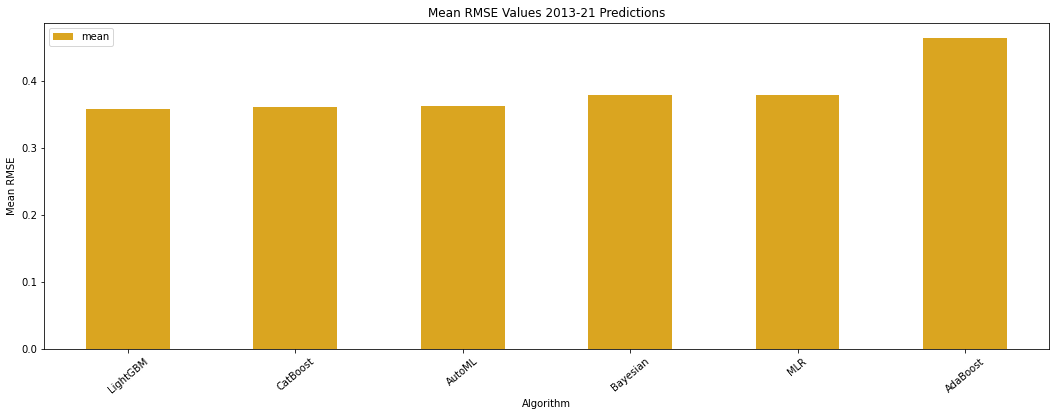

In [263]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Mean RMSE', title='Mean RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MEDAE'>

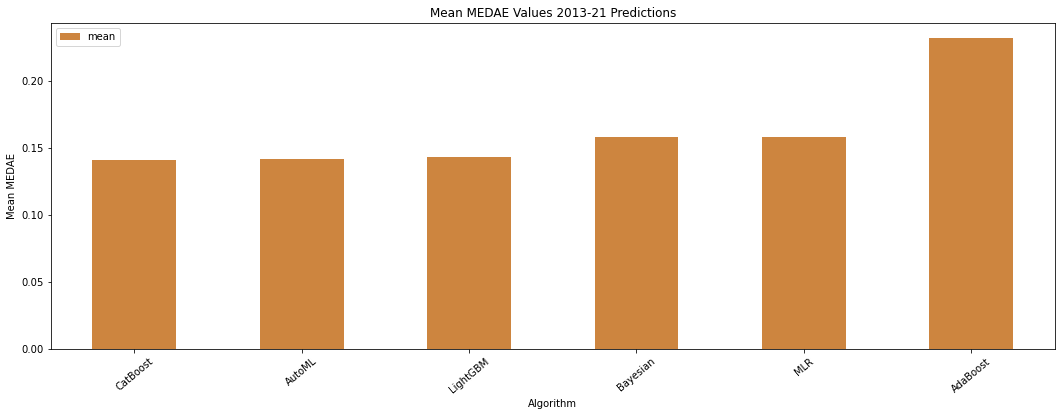

In [264]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Mean MEDAE', title='Mean MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

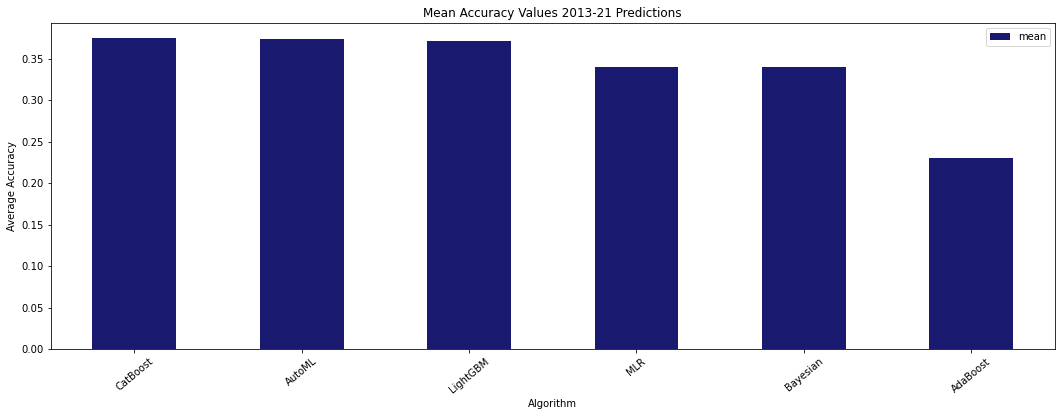

In [265]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum', 'min']})
grouped_multiple3.columns = ['mean','median','max','sum', 'min']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MSE'>

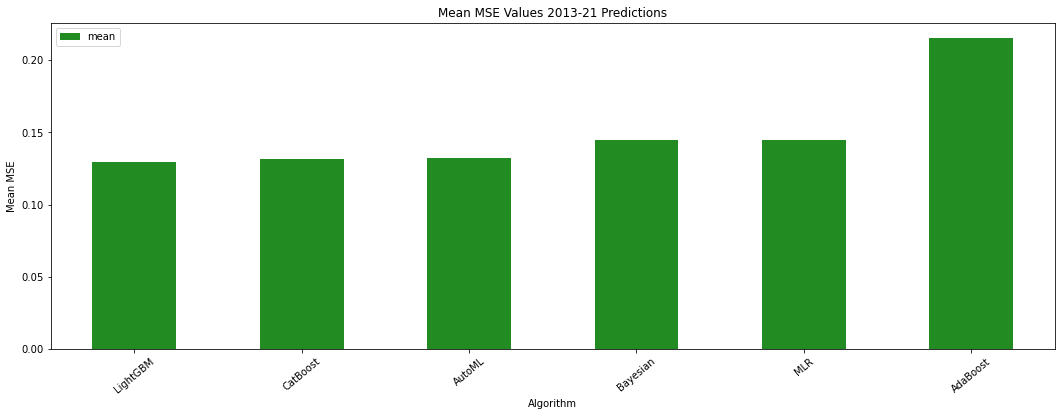

In [266]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Mean MSE', title='Mean MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

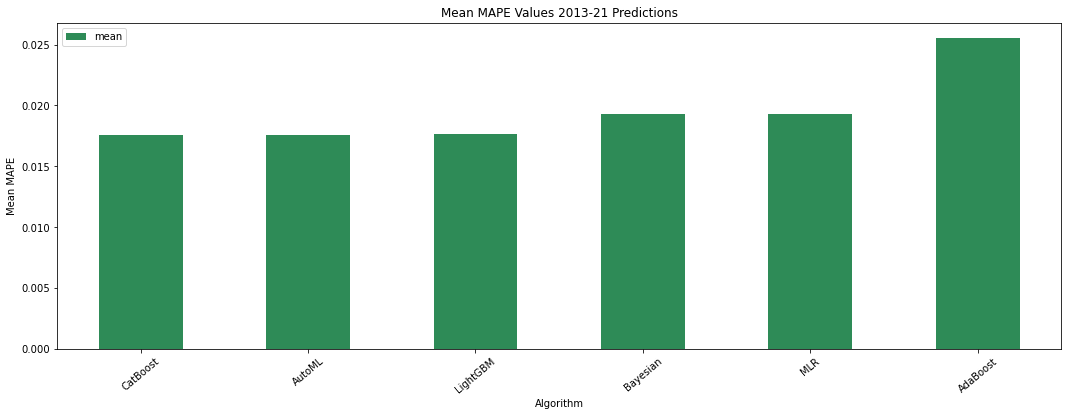

In [267]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

Result that can be compared around 6/7 % off [this](https://arxiv.org/pdf/2108.09175.pdf), (slightly diff approach taken by me predicting yearly however!)

In [268]:
grouped_multiple3.sort_values(by = 'mean', ascending = False)

,Algorithm,mean,median,max,sum,min
3,CatBoost,0.374311,0.374898,0.397315,1.871555,0.346625
1,AutoML,0.374217,0.377959,0.390438,1.871086,0.355513
4,LightGBM,0.371392,0.379744,0.395217,1.856959,0.332212
5,MLR,0.339749,0.342395,0.351017,1.698745,0.321403
2,Bayesian,0.339496,0.342150,0.351017,1.697479,0.319962
0,AdaBoost,0.230821,0.214391,0.274691,1.154106,0.192857


<AxesSubplot:title={'center':'Performance of ML algorithms accuracy from 2017-2021 Predictions'}, xlabel='Year'>

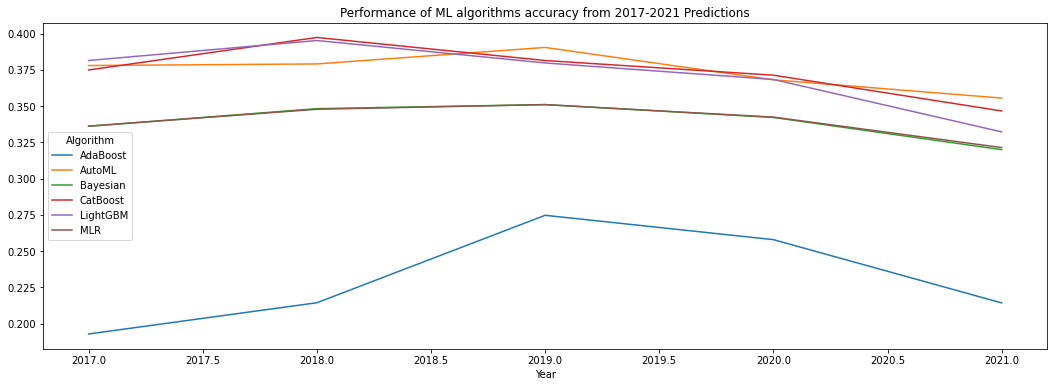

In [269]:
# yearly accuracy results
df = vis2.pivot(index = 'Year', columns = 'Algorithm', values = 'Accuracy')
df.plot(figsize = (18, 6), title = 'Performance of ML algorithms accuracy from 2017-2021 Predictions')